<a href="https://colab.research.google.com/github/mahi97/MahiColabs/blob/master/auto_encoder_convolutinoal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:
!pip install keras
import tensorflow as tf
import math
import matplotlib.pyplot as plt
import numpy as np

In [0]:
def corrupt(x):
    """Take an input tensor and add uniform masking.
    Parameters
    ----------
    x : Tensor/Placeholder
        Input to corrupt.
    Returns
    -------
    x_corrupted : Tensor
        50 pct of values corrupted.
    """
    return tf.multiply(x, tf.cast(tf.random_uniform(shape=tf.shape(x),
                                               minval=0,
                                               maxval=2,
                                               dtype=tf.int32), tf.float64))

In [0]:
def lrelu(x, leak=0.2, name="lrelu"):
    """Leaky rectifier.
    Parameters
    ----------
    x : Tensor
        The tensor to apply the nonlinearity to.
    leak : float, optional
        Leakage parameter.
    name : str, optional
        Variable scope to use.
    Returns
    -------
    x : Tensor
        Output of the nonlinearity.
    """
    with tf.variable_scope(name):
        f1 = 0.5 * (1 + leak)
        f2 = 0.5 * (1 - leak)
        return f1 * x + f2 * abs(x)

In [0]:
def autoencoder(input_shape=[None, 784],
                n_filters=[1, 10, 10, 10],
                filter_sizes=[3, 3, 3, 3],
                corruption=False):
  x = tf.placeholder(tf.float64, input_shape, name='x')
  
  # Probability that we will corrupt input.
  # This is the essence of the denoising autoencoder, and is pretty
  # basic.  We'll feed forward a noisy input, allowing our network
  # to generalize better, possibly, to occlusions of what we're
  # really interested in.  But to measure accuracy, we'll still
  # enforce a training signal which measures the original image's
  # reconstruction cost.
  #
  # We'll change this to 1 during training
  # but when we're ready for testing/production ready environments,
  # we'll put it back to 0.
  corrupt_prob = tf.placeholder(tf.float64, [1])
  if corruption:
    x_noise = corrupt(x)
  else:
    x_noise = x

  if len(x.get_shape()) == 2:
    x_dim = np.sqrt(x_noise.get_shape().as_list()[1])
    if x_dim != int(x_dim):
      raise ValueError('Unsupported input dimensions')
    x_dim = int(x_dim)
    x_tensor = tf.reshape(x_noise, [-1, x_dim, x_dim, n_filters[0]])
  elif len(x_noise.get_shape()) == 4:
    x_tensor = x_noise
  else:
    raise ValueError('Unsupported input dimensions')

  current_input = x_tensor;
    
  encoder = []
  shapes = []
  for layer_i, n_output in enumerate(n_filters[1:]):
      n_input = current_input.get_shape().as_list()[3]
      shapes.append(current_input.get_shape().as_list())
      W = tf.Variable(
          tf.random_uniform([
              filter_sizes[layer_i], 
              filter_sizes[layer_i],
              n_input, n_output],
                            -1.0 / math.sqrt(n_input),
                            1.0 / math.sqrt(n_input), dtype=tf.float64))
      b = tf.Variable(tf.zeros([n_output], dtype=tf.float64))
      encoder.append(W)
      output = lrelu(
          tf.add(
          tf.nn.conv2d(
              current_input, W, strides=[1,2,2,1], padding='SAME'),
              b)
      )
      
      current_input = output

  # %% latent representation
  z = current_input
  encoder.reverse()
  shapes.reverse()
  # %% Build the decoder using the same weights
  for layer_i, shape in enumerate(shapes):
      W = encoder[layer_i] # tf.transpose(encoder[layer_i])
      b = tf.Variable(tf.zeros([W.get_shape().as_list()[2]], dtype=tf.float64))
      output = lrelu(
        tf.add(
          tf.nn.conv2d_transpose(
              current_input, W,
              tf.stack([tf.shape(x)[0], shape[1], shape[2], shape[3]]),
              strides=[1, 2, 2, 1], padding='SAME'
          ), 
          b
        )
      )
      current_input = output

  # %% now have the reconstruction through the network
  y = current_input

  # %% cost function measures pixel-wise difference
  cost = tf.reduce_sum(tf.square(y - x_tensor))
  return {'x': x, 'z': z, 'y': y, 'cost': cost}

In [0]:
import tensorflow.keras.datasets.mnist as mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train / 255.0
X_test = X_test / 255.0
y_test = [[0 == b,
                   1 == b,
                   2 == b,
                   3 == b,
                   4 == b,
                   5 == b,
                   6 == b,
                   7 == b,
                   8 == b,
                   9 == b] for b in y_test]
y_train = [[0 == b,
                   1 == b,
                   2 == b,
                   3 == b,
                   4 == b,
                   5 == b,
                   6 == b,
                   7 == b,
                   8 == b,
                   9 == b] for b in y_train]

In [0]:
"""Test the autoencoder using MNIST."""
mean_img = np.mean(X_train, axis=0)
ae = autoencoder()

# %%
learning_rate = 0.001
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(ae['cost'])

# %%
# We create a session to use the graph
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [35]:
# %%
# Fit all training data
batch_size = 100
n_epochs = 10
for epoch_i in range(n_epochs):
    for batch_i in range(X_train.shape[0] // batch_size):
      batch_xs = X_train[batch_i * batch_size: (batch_i + 1) * batch_size]
      train = np.array([img - mean_img for img in batch_xs]).reshape(batch_size,784)
      sess.run(optimizer, feed_dict={ae['x']: train})
    print(epoch_i, sess.run(ae['cost'], feed_dict={ae['x']: train}))

0 2017.1037866295949
1 1368.1818488015729
2 1103.1167106044245
3 1017.1264546910845
4 963.3714009153728
5 914.0868872835936
6 872.5095869882869
7 838.5243672945537
8 811.9625543578875
9 791.5936671764218


0


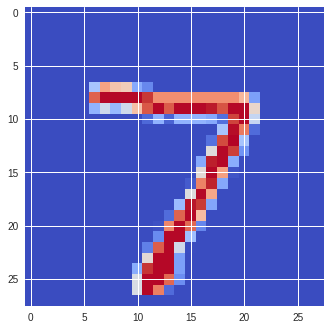

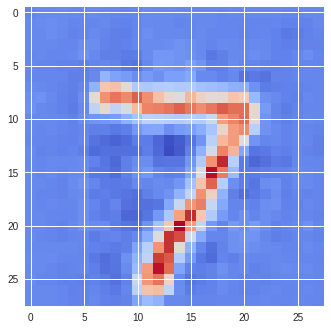

1


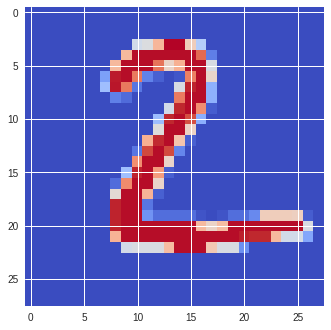

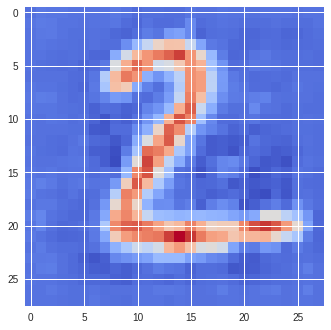

2


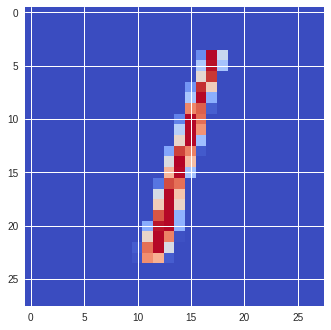

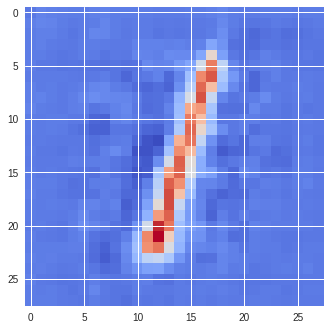

3


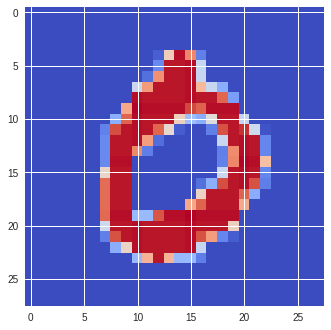

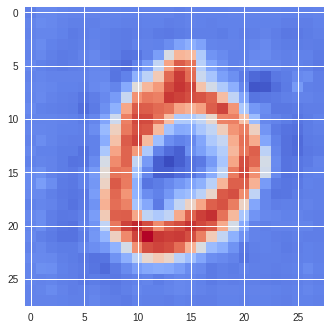

4


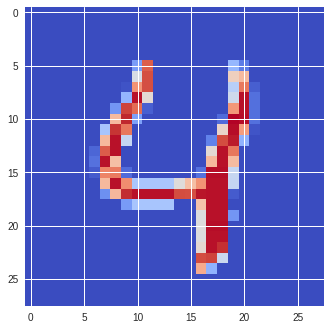

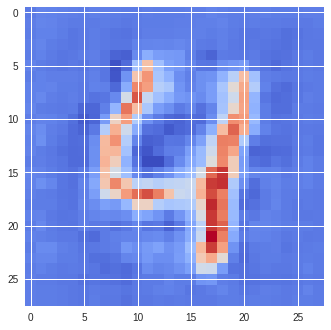

5


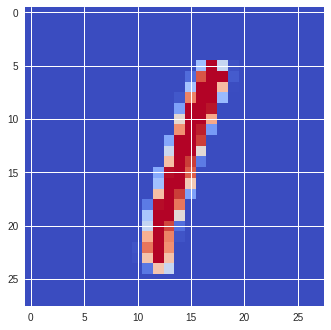

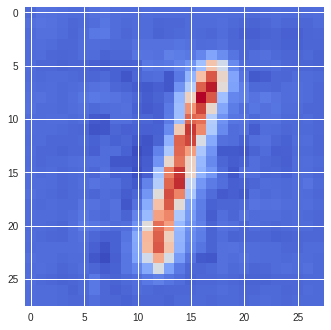

6


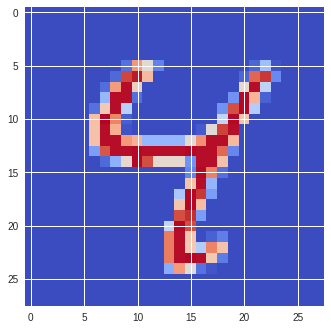

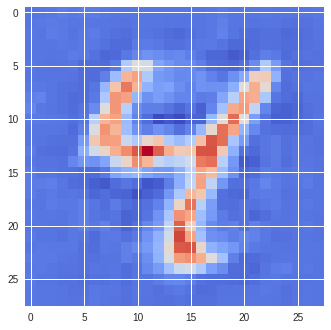

7


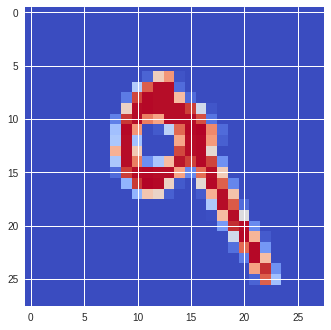

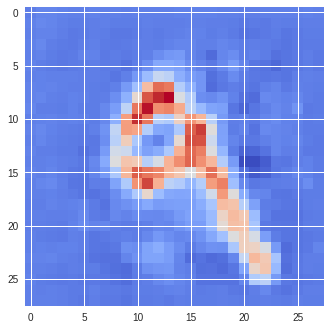

8


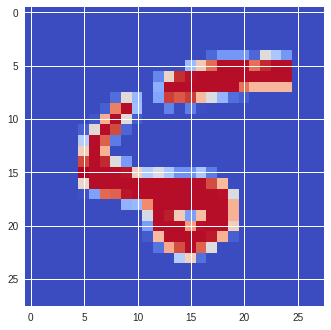

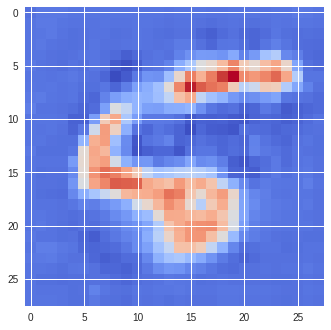

9


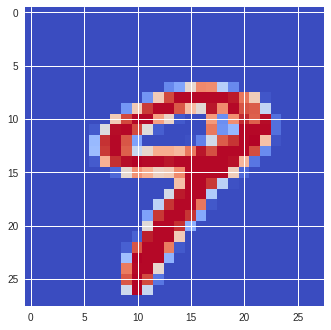

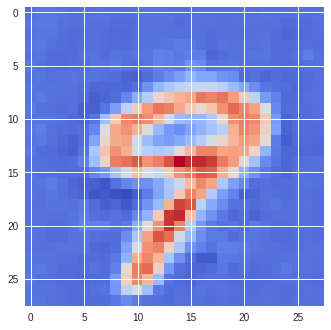

10


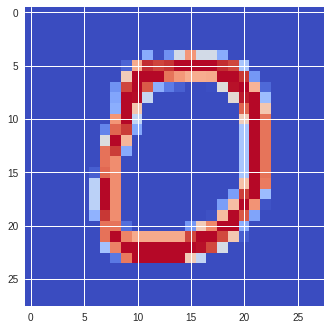

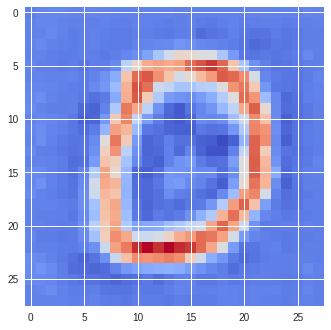

11


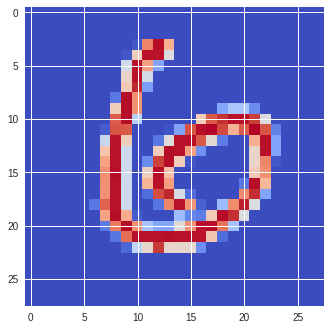

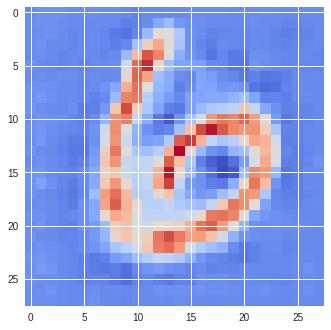

12


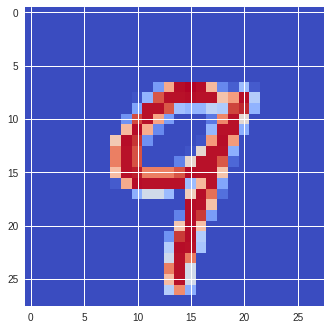

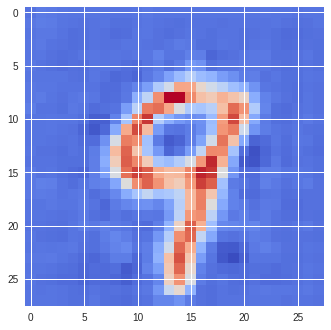

13


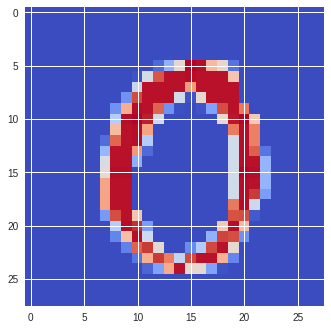

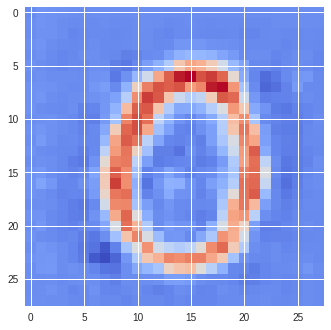

14


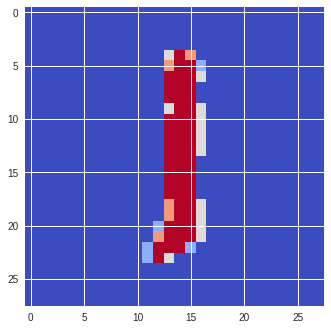

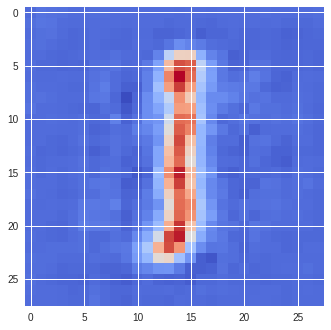

In [38]:
# Plot example reconstructions
n_examples = 15
mean_img = np.mean(X_train, axis=0)
test_xs =X_test[0 * n_examples: (0 + 1) * n_examples]
test_xs_norm = np.array([img - mean_img for img in test_xs]).reshape(n_examples,784)
recon = sess.run(ae['y'], feed_dict={ae['x']: test_xs_norm})
for example_i in range(n_examples):
    print(example_i)
    plt.imshow(
        np.reshape(test_xs[example_i, :], (28, 28)), cmap='coolwarm')
    plt.show()
    plt.imshow(
        np.reshape(np.reshape(recon[example_i, :], (784,)) + mean_img.reshape(784,), (28, 28)),
        cmap='coolwarm')
    plt.show()